In [1]:
import open3d as o3d

In [2]:
import numpy as np
import math
import random
import os
import torch
import scipy.spatial.distance
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from path import Path

import plotly.graph_objects as go
import plotly.express as px

In [3]:
def fix_seed(seed):
    # random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

SEED = 42
fix_seed(SEED)

In [4]:
# output_sizeになるように1データの点群数を削除
class PointSampler(object):
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size
    
    def __call__(self, data):
        return data[:self.output_size]

In [5]:
class Normalize(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape) == 2

        # x, y, z軸で平均を引く→各ベクトルの大きさの最大値で各要素を割る
        norm_pointcloud = pointcloud - np.mean(pointcloud, axis=0)
        norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))

        return norm_pointcloud

In [6]:
class ToTensor(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape) == 2

        return torch.from_numpy(pointcloud)

In [7]:
def default_transforms():
    return transforms.Compose([
        PointSampler(1000),
        Normalize(),
        ToTensor()
    ])

In [8]:
def read_pcd(path):
    pcd = o3d.io.read_point_cloud(path)
    points = np.array(pcd.points)
    return points

In [9]:
# Custom Pytorch Datasetオブジェクトの作成

class PointCloudData(Dataset):
    def __init__(self, root_dir, valid=False, folder="train", transform=default_transforms()):
        self.root_dir = root_dir
        folders = [dir for dir in sorted(os.listdir(root_dir)) if os.path.isdir(root_dir/dir)]
        self.classes = {folder:i for i, folder in enumerate(folders)}
        self.transforms = transform if not valid else default_transforms()
        self.valid = valid
        self.files = []

        for category in self.classes.keys():
            new_dir = root_dir/Path(category)/folder
            for file in os.listdir(new_dir):
                if file.endswith('.pcd'):
                    # PCDファイルからpcd.points読み込み
                    sample = {}
                    sample['pcd_path'] = new_dir/file
                    sample['category'] = category
                    self.files.append(sample)
    
    def __len__(self):
        return len(self.files)
    
    def __preproc__(self, path):
        points = read_pcd(path)
        if self.transforms:
            pointcloud = self.transforms(points)
        return pointcloud
    
    def __getitem__(self, idx):
        pcd_path = self.files[idx]['pcd_path']
        category = self.files[idx]['category']
        pointcloud = self.__preproc__(pcd_path)
        return {'pointcloud': pointcloud, 'category': self.classes[category]}
                    

In [10]:
path = Path("../Data/five_position_classes_head")

In [11]:
folders = [dir for dir in sorted(os.listdir(path)) if os.path.isdir(path/dir)]
classes = {folder: i for i, folder in enumerate(folders)}
classes

{'0': 0, 'l45': 1, 'l90': 2, 'r45': 3, 'r90': 4}

In [12]:
train_ds = PointCloudData(path)
valid_ds = PointCloudData(path, valid=True, folder='valid')

In [13]:
inv_classes = {i:cat for cat, i in train_ds.classes.items()}
inv_classes

{0: '0', 1: 'l45', 2: 'l90', 3: 'r45', 4: 'r90'}

In [14]:
print('Train dataset size: ', len(train_ds))
print('Valid dataset size: ', len(valid_ds))
print('Number of classes: ', len(train_ds.classes))
print('Sample pointcloud shape: ', train_ds[-1]['pointcloud'].size())
print('Class: ', inv_classes[train_ds[0]['category']])

Train dataset size:  503
Valid dataset size:  150
Number of classes:  5
Sample pointcloud shape:  torch.Size([1000, 3])
Class:  0


In [15]:
print(train_ds[-1]['pointcloud'].size())

torch.Size([1000, 3])


In [16]:
train_loader = DataLoader(dataset=train_ds, batch_size=10, shuffle=True)
valid_loader = DataLoader(dataset=valid_ds, batch_size=10, shuffle=True)

In [17]:
print(train_loader)

In [18]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

class Tnet(nn.Module):
   def __init__(self, k=3):
      super().__init__()
      self.k=k
      self.conv1 = nn.Conv1d(k,64,1)
      self.conv2 = nn.Conv1d(64,128,1)
      self.conv3 = nn.Conv1d(128,1024,1)
      self.fc1 = nn.Linear(1024,512)
      self.fc2 = nn.Linear(512,256)
      self.fc3 = nn.Linear(256,k*k)

      self.bn1 = nn.BatchNorm1d(64)
      self.bn2 = nn.BatchNorm1d(128)
      self.bn3 = nn.BatchNorm1d(1024)
      self.bn4 = nn.BatchNorm1d(512)
      self.bn5 = nn.BatchNorm1d(256)
       

   def forward(self, input):
      # input.shape == (bs,n,3)
      bs = input.size(0)
      xb = F.relu(self.bn1(self.conv1(input)))
      xb = F.relu(self.bn2(self.conv2(xb)))
      xb = F.relu(self.bn3(self.conv3(xb)))
      pool = nn.MaxPool1d(xb.size(-1))(xb)
      flat = nn.Flatten(1)(pool)
      xb = F.relu(self.bn4(self.fc1(flat)))
      xb = F.relu(self.bn5(self.fc2(xb)))
      
      #initialize as identity
      init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
      if xb.is_cuda:
        init=init.cuda()
      matrix = self.fc3(xb).view(-1,self.k,self.k) + init
      return matrix


class Transform(nn.Module):
   def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k=3)
        self.feature_transform = Tnet(k=64)
        self.conv1 = nn.Conv1d(3,64,1)

        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)
       

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
       
   def forward(self, input):
        matrix3x3 = self.input_transform(input)
        # batch matrix multiplication
        xb = torch.bmm(torch.transpose(input,1,2), matrix3x3).transpose(1,2)

        xb = F.relu(self.bn1(self.conv1(xb)))

        matrix64x64 = self.feature_transform(xb)
        xb = torch.bmm(torch.transpose(xb,1,2), matrix64x64).transpose(1,2)

        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = self.bn3(self.conv3(xb))
        xb = nn.MaxPool1d(xb.size(-1))(xb)
        output = nn.Flatten(1)(xb)
        return output, matrix3x3, matrix64x64

class PointNet(nn.Module):
    def __init__(self, classes = 10):
        super().__init__()
        self.transform = Transform()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)
        

        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.3)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        xb, matrix3x3, matrix64x64 = self.transform(input)
        xb = F.relu(self.bn1(self.fc1(xb)))
        xb = F.relu(self.bn2(self.dropout(self.fc2(xb))))
        output = self.fc3(xb)
        return self.logsoftmax(output), matrix3x3, matrix64x64

In [19]:
def pointnetloss(outputs, labels, m3x3, m64x64, alpha = 0.0001):
    criterion = torch.nn.NLLLoss()
    bs=outputs.size(0)
    id3x3 = torch.eye(3, requires_grad=True).repeat(bs,1,1)
    id64x64 = torch.eye(64, requires_grad=True).repeat(bs,1,1)
    if outputs.is_cuda:
        id3x3=id3x3.cuda()
        id64x64=id64x64.cuda()
    diff3x3 = id3x3-torch.bmm(m3x3,m3x3.transpose(1,2))
    diff64x64 = id64x64-torch.bmm(m64x64,m64x64.transpose(1,2))
    return criterion(outputs, labels) + alpha * (torch.norm(diff3x3)+torch.norm(diff64x64)) / float(bs)

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [21]:
pointnet = PointNet(classes=5)
pointnet.to(device)

PointNet(
  (transform): Transform(
    (input_transform): Tnet(
      (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
      (fc1): Linear(in_features=1024, out_features=512, bias=True)
      (fc2): Linear(in_features=512, out_features=256, bias=True)
      (fc3): Linear(in_features=256, out_features=9, bias=True)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (feature_transform): Tnet(
      (conv1): Conv1d(64, 64, kernel_size=(1,

In [22]:
optimizer = torch.optim.Adam(pointnet.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=90, gamma=0.1)

In [23]:
# Visdom を使う場合はこことtrain内のコメントアウトを外す
# from visdom import Visdom

# viz = Visdom()

In [24]:
def train(model, train_loader, val_loader=None,  epochs=15, save=True):
    for epoch in range(epochs): 
        pointnet.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
            optimizer.zero_grad()
            outputs, m3x3, m64x64 = pointnet(inputs.transpose(1,2))

            loss = pointnetloss(outputs, labels, m3x3, m64x64)
            loss.backward()
            optimizer.step()
            scheduler.step()

            # print statistics
            running_loss += loss.item()
            if i % 10 == 9:    # print every 10 mini-batches
                    print('[Epoch: %d, Batch: %4d / %4d], loss: %.3f, lr: %f' %
                        (epoch + 1, i + 1, len(train_loader), running_loss / 10, scheduler.get_lr()[0]))
                    running_loss = 0.0

        pointnet.eval()
        correct = total = 0

        # validation
        if val_loader:
            with torch.no_grad():
                for data in val_loader:
                    inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
                    outputs, __, __ = pointnet(inputs.transpose(1,2))
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            val_acc = 100. * correct / total
            print('Valid accuracy: %d %%' % val_acc)

            # viz.line(X=np.array([epoch]), Y=np.array([running_loss]), win='loss', name='avg_train_loss', update='append')
            # viz.line(X=np.array([epoch]), Y=np.array([val_acc]), win='acc', name='avg_test_acc', update='append')

    # save the model
    if save:
        torch.save(pointnet.state_dict(), "pnt_model_500.pth")

In [25]:
train(pointnet, train_loader, valid_loader, save=True)

[Epoch: 1, Batch:   10 /   51], loss: 1.652, lr: 0.001000
[Epoch: 1, Batch:   20 /   51], loss: 1.309, lr: 0.001000
[Epoch: 1, Batch:   30 /   51], loss: 0.974, lr: 0.001000
[Epoch: 1, Batch:   40 /   51], loss: 0.880, lr: 0.001000
[Epoch: 1, Batch:   50 /   51], loss: 0.630, lr: 0.001000
Valid accuracy: 54 %
[Epoch: 2, Batch:   10 /   51], loss: 0.752, lr: 0.001000
[Epoch: 2, Batch:   20 /   51], loss: 0.719, lr: 0.001000
[Epoch: 2, Batch:   30 /   51], loss: 0.768, lr: 0.001000
[Epoch: 2, Batch:   40 /   51], loss: 0.497, lr: 0.000100
[Epoch: 2, Batch:   50 /   51], loss: 0.558, lr: 0.000100
Valid accuracy: 90 %
[Epoch: 3, Batch:   10 /   51], loss: 0.523, lr: 0.000100
[Epoch: 3, Batch:   20 /   51], loss: 0.603, lr: 0.000100
[Epoch: 3, Batch:   30 /   51], loss: 0.438, lr: 0.000100
[Epoch: 3, Batch:   40 /   51], loss: 0.360, lr: 0.000100
[Epoch: 3, Batch:   50 /   51], loss: 0.288, lr: 0.000100
Valid accuracy: 92 %
[Epoch: 4, Batch:   10 /   51], loss: 0.228, lr: 0.000100
[Epoch: 4

In [26]:
from sklearn.metrics import confusion_matrix

In [27]:
pointnet = PointNet(classes=5)
pointnet.load_state_dict(torch.load('pnt_model_500.pth'))
pointnet.to(device)
pointnet.eval()

PointNet(
  (transform): Transform(
    (input_transform): Tnet(
      (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
      (fc1): Linear(in_features=1024, out_features=512, bias=True)
      (fc2): Linear(in_features=512, out_features=256, bias=True)
      (fc3): Linear(in_features=256, out_features=9, bias=True)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (feature_transform): Tnet(
      (conv1): Conv1d(64, 64, kernel_size=(1,

In [29]:
all_preds = []
all_labels = []
with torch.no_grad():
    for i, data in enumerate(valid_loader):
        print('Batch [%4d / %4d]' % (i+1, len(valid_loader)))
                   
        inputs, labels = data['pointcloud'].to(device).float(), data['category']
        outputs, __, __ = pointnet(inputs.transpose(1,2))
        _, preds = torch.max(outputs.data, 1)
        all_preds += list(preds.cpu().numpy())
        all_labels += list(labels.numpy())
        


Batch [   1 /   15]
Batch [   2 /   15]
Batch [   3 /   15]
Batch [   4 /   15]
Batch [   5 /   15]
Batch [   6 /   15]
Batch [   7 /   15]
Batch [   8 /   15]
Batch [   9 /   15]
Batch [  10 /   15]
Batch [  11 /   15]
Batch [  12 /   15]
Batch [  13 /   15]
Batch [  14 /   15]
Batch [  15 /   15]


In [30]:
cm = confusion_matrix(all_labels, all_preds)
cm

array([[30,  0,  0,  0,  0],
       [ 6, 23,  1,  0,  0],
       [ 0,  0, 28,  0,  2],
       [ 0,  0,  0, 30,  0],
       [ 0,  0,  0,  0, 30]])

In [31]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

# function from https://deeplizard.com/learn/video/0LhiS6yu2qQ
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


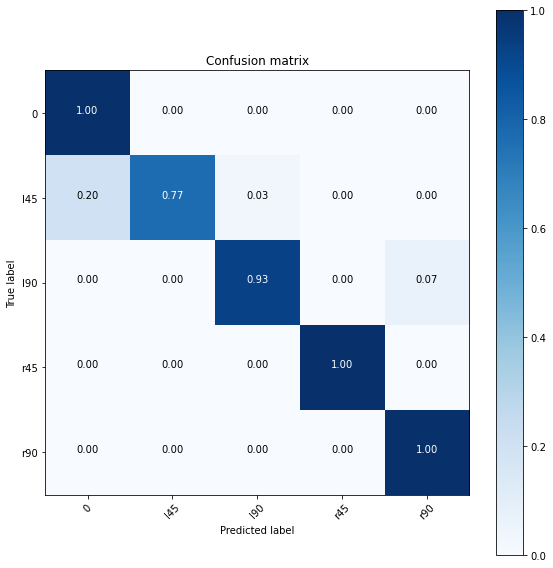

In [32]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(classes.keys()), normalize=True)

Confusion matrix, without normalization


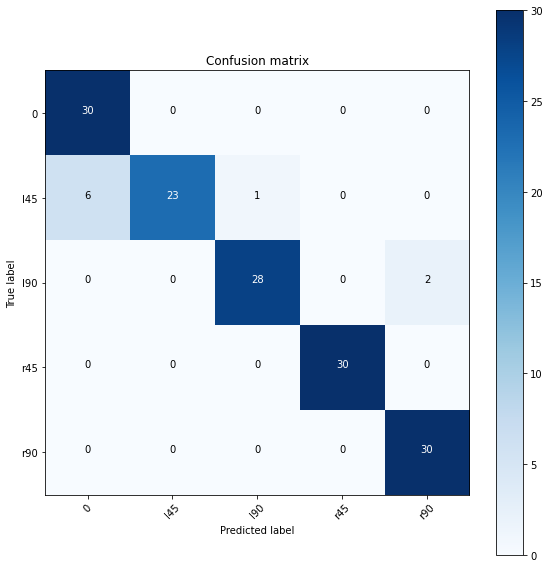

In [33]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(classes.keys()), normalize=False)

In [35]:
dummy = torch.randn(1, 1000, 3).to(device)

dummy_out, dummy_3x3, dummy_64x64 = pointnet(dummy.transpose(1, 2))
print(f"output: {dummy_out}\n")
print(f"m3x3: {dummy_3x3}\n")
print(f"m64x64: {dummy_64x64}")

output: tensor([[-2726.4375, -3350.6479, -3481.4263,     0.0000,  -531.5422]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward>)

m3x3: tensor([[[  2.1532, -12.7443,  -7.6026],
         [ -3.9734,   6.2352,  -0.4875],
         [-14.9838,  25.4670,  -1.6499]]], device='cuda:0',
       grad_fn=<AddBackward0>)

m64x64: tensor([[[ 4.2424e+01, -4.0089e+01,  9.0097e+00,  ..., -2.2276e+00,
           1.2126e+01, -7.2893e+01],
         [-2.4374e+00,  2.2829e+01,  3.8284e+01,  ...,  3.0780e+01,
          -9.0667e+00,  4.0305e+01],
         [-2.7274e+00,  1.3127e+01, -3.3165e+01,  ...,  3.7083e+01,
          -3.6033e+01,  2.1701e+00],
         ...,
         [-3.5659e+01,  4.8327e-01, -2.8351e+01,  ...,  2.6171e+00,
           1.0935e+01,  2.6207e+01],
         [ 2.8511e+01,  1.1832e+01, -2.3844e+01,  ...,  1.7260e+01,
           4.4211e+01, -1.1311e+01],
         [ 4.9325e+00,  4.3680e+01,  2.8261e-02,  ...,  6.1876e+00,
           1.3399e+01, -1.3147e+01]]], device='cuda:0', grad_fn=<AddBac

In [36]:
# from torchviz import make_dot

# model = PointNet(classes=5)
# make_dot((dummy_out, dummy_3x3, dummy_64x64))

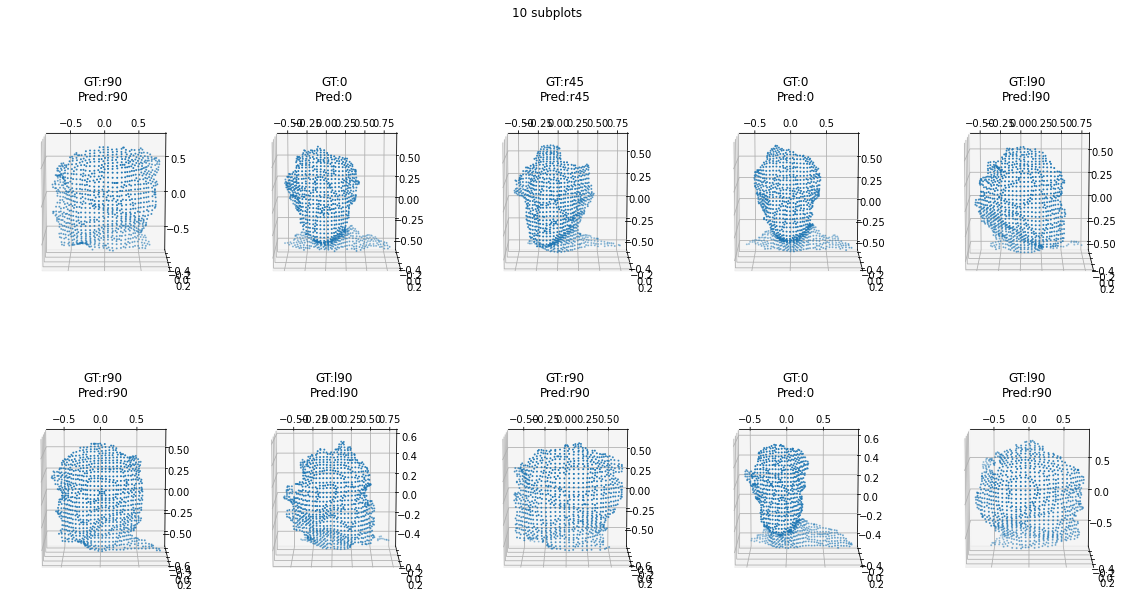

In [59]:
# visualize
from mpl_toolkits.mplot3d import Axes3D


test_batch = next(iter(valid_loader))
test_inputs = test_batch['pointcloud']
test_inputs = test_inputs.to(device).float()
# print(test_inputs)
labels = test_batch['category']
outputs, __, __ = pointnet(test_inputs.transpose(1,2))
_, preds = torch.max(outputs.data, 1)

# convert data
test_inputs = list(test_inputs.cpu().numpy())
preds = list(preds.cpu().numpy())
labels = list(labels.cpu().numpy())

fig = plt.figure(figsize=(20, 10))
fig.suptitle('10 subplots')

for i, test_input, label, pred in zip(range(1, 11), test_inputs, labels, preds):
    points = np.array(test_input)
    X = points[:, 0]
    Y = points[:, 1]
    Z = points[:, 2]
    ax = fig.add_subplot(2, 5, i, projection='3d')
    # elevはz軸方向から見た仰角，azimはx, y軸方向の方位角を指定．
    ax.view_init(elev=100, azim=270)
    ax.scatter3D(X, Y, Z, s=1)
    ax.set_title(f"GT:{inv_classes[int(label)]}\nPred:{inv_classes[int(pred)]}")
plt.show()